# AIC-5102B Lab 2 / Text classification

The aim of this lab is to use LDA and its kernelized version to perform text classification. You should work under Linux on ESIEE's machines, where the proper execution of the lab is guaranteed.


## 1. Setup


You are free to choose the working dataset you wish to work with from Kaggle amongnst the following :
- Ecommerce Text Classification
- BBC Full Text Document Classification
- Text Classification on Emails
- Spam Text Message Classification

See https://www.kaggle.com/datasets?search=text+classification

Moreover, to alleviate the problem we will work with only 2 classes, so you will also have to choose 2 classes amongst those offered by your dataset.

You should choose a dataset which contains documents which are long enough, otherwise it is unlikely that the specialized kernel of part 4 will help. Tweets, in particular, are discouraged for that reason. If you wish to use another dataset that those mentioned above, simply ask me for validation.

Which dataset and classes did you chose ? Copy the related files to your working directory.

## 2. Text vectorization

The following functions :
- extract the vocabulary from row #5 (that number is arbitrary) of the specified CSV file 
- build the document-term matrix by reading again the same CSV file

Adapt them, so that they fit your dataset and produce a D-T matrix in the end.

Please note that:
- the tokenization method used is wordpunct_tokenize(), which may not be optimal. You may call something different in case you find really too much garbage in your resulting vocabulary.
- there are two "if" tests in dtmat_from_file which appear unnecessary so far. They are, indeed, because the test samples may include unseen words, which would generate out-of-bounds index. So unseen words are just ignored.
- you may also want to lemmatize. 

In [1]:
import csv
import nltk
import numpy as np

def voc_from_csv(csvfile):
    nlines=0
    voc=[]
    with open(csvfile, errors='ignore') as file:
        reader=csv.reader(file, delimiter=',')
        for row in reader:
            nlines=nlines+1
            voc.extend(nltk.wordpunct_tokenize(row[1]))
    voc=sorted(set(voc))        
    return voc,nlines

def dtmat_from_csv(csvfile):
    voc,rows=voc_from_csv(csvfile)
    cols=len(voc)
    mat=np.zeros((rows,cols))
    d=0
    with open(csvfile,  errors='ignore') as file:
        reader=csv.reader(file, delimiter=',')
        for row in reader:
            w= nltk.wordpunct_tokenize(row[1])
            X=np.searchsorted(voc,w,side='left')            
            for i in range(0,len(w)):
                if (X[i] < cols):
                    if (w[i] == voc[X[i]]):
                        mat[d][X[i]]+=1
            d=d+1
    return mat

### Question 1 

Run dtmat_from_csv on one of your sample dataset. Examine the resulting matrix. How many times does it happen that a given word is seen only once (possibly twice) in your training set ? Give a few lines which show this below.

In [2]:
csvfile = 'spam_text_message_classification_dataset.csv'
document_term_matrix = dtmat_from_csv(csvfile)
word_occurrences = np.sum(document_term_matrix, axis=0)
words_appearing_once = np.sum((word_occurrences == 1))
words_appearing_twice = np.sum((word_occurrences == 2))
print(f"Number of words appearing only once: {words_appearing_once}")
print(f"Number of words appearing only twice: {words_appearing_twice}")

Number of words appearing only once: 5797
Number of words appearing only twice: 1833


### Question 2

Suppose we use ordinary LDA to separate positive from negative samples, computed by voc_from_csv(). What will be the effect of an increasing number of "seen only once" words :
- on the memory complexity of the solution ?
- on the solution itself ?

Write your answer below, either in plain language or using LaTeX notation for formulas if you prefer. This question is purely theoretical and does not require any programming.

In [3]:
# When using ordinary LDA to separate positive from negative samples, an increasing number of "seen only once" words can have the following effects:

# 1. Memory Complexity:
#    - Increase in Memory Usage

# 2. Effect on the Solution:
#    - Sparse and Noisy Representation
#    - Overfitting Risk

# The memory complexity can be approximated as
# $$O(N \times V \times M)$$
# With
# - $N$ number of documents.
# - $V$ number of words in the vocabulary.
# - $M$ be the number of "seen only once" words.

### Question 3

No matter what your answer to question 2 is, add a boolean parameter to voc_from_csv(), say "purge", so that when "purge" is True, the "only seen once" words are *not* included in the vocabulary. There is no need to modify dtmat_from_csv(),which has already been written to take this into account, except from the call to voc_from_csv().
Change the block below accordingly:

In [4]:
import csv
import nltk
import numpy as np

def voc_from_csv(csvfile, purge=True):
    nlines = 0
    voc = []
    word_count = {}

    with open(csvfile, errors='ignore') as file:
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            nlines += 1
            tokens = nltk.wordpunct_tokenize(row[1])
            voc.extend(tokens)

            for token in set(tokens):
                word_count[token] = word_count.get(token, 0) + 1

    if purge:
        voc = [word for word in set(voc) if word_count[word] > 1]

    voc = sorted(voc)
    return voc, nlines

def dtmat_from_csv(csvfile, vocabulary=None):
    if vocabulary is None:
        vocabulary, rows = voc_from_csv(csvfile)
    else:
        rows = sum(1 for _ in open(csvfile, 'r', errors='ignore'))  # Count rows without reading the file again

    cols = len(vocabulary)
    mat = np.zeros((rows, cols), dtype=int)
    d = 0

    with open(csvfile, errors='ignore') as file:
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            w = nltk.wordpunct_tokenize(row[1])
            X = np.searchsorted(vocabulary, w, side='left')
            for i in range(len(w)):
                if X[i] < cols and w[i] == vocabulary[X[i]]:
                    mat[d][X[i]] += 1
            d += 1

    return mat

csvfile = 'spam_text_message_classification_dataset.csv'
document_term_matrix = dtmat_from_csv(csvfile)
word_occurrences = np.sum(document_term_matrix, axis=0)
words_appearing_once = np.sum((word_occurrences == 1))
print(f"Number of words appearing only once: {words_appearing_once}")

Number of words appearing only once: 0


## 3. Ordinary LDA

### Question 4

Write an lda(X1,X2) function which computes and returns the direction predicted by the ordinary LDA given samples X1 and X2, which should be passed as matrices of row vectors. The function should return:
- $\boldsymbol{u}$, the optimal direction
- and $s$, the abscissa of the hyperplane (the linear discriminant) on $\boldsymbol{u}$ which optimally separates the data assuming they are normally distributed after their projection on $\boldsymbol{u}$


In [5]:
import numpy as np

def lda(X1, X2):
    mu1 = np.mean(X1, axis=0)
    mu2 = np.mean(X2, axis=0)
    mu = (mu1 + mu2) / 2
    
    S1 = np.cov(X1.T)
    S2 = np.cov(X2.T)
    Sw = S1 + S2

    u = np.linalg.inv(Sw) @ (mu1 - mu2)
    s = u @ mu
    
    return u, s

### Question 5

Test your function on a toy sample. Count how many points are correcly classified. You may use/extend/modify the following piece of code:

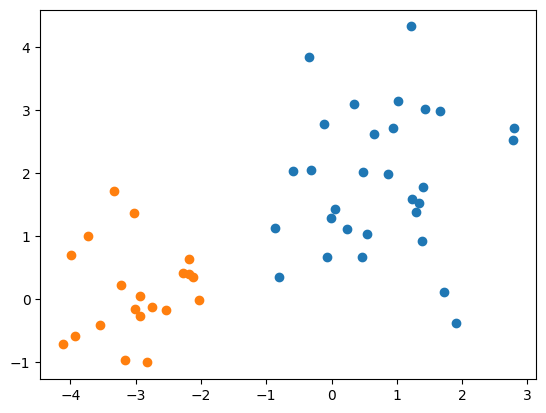

[2.74450884 0.76636322] -2.2963456033826417


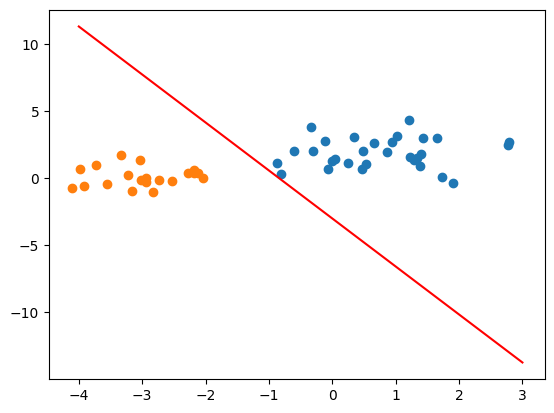

number of points in class 1: 30
number of points in class 2: 20


In [6]:
import matplotlib.pyplot as plt

X1=np.random.multivariate_normal([1,2], np.identity(2),30)
X2=np.random.multivariate_normal([-3,0], 0.5*np.identity(2),20)
plt.scatter(X1[:,0],X1[:,1])
plt.scatter(X2[:,0],X2[:,1])
plt.show()
u,s= lda(X1,X2)
print(u,s)

x = np.linspace(-4, 3, 100)
y = (s - u[0] * x) / u[1]
plt.plot(x, y, '-r', label='y=2x+1')
plt.scatter(X1[:,0],X1[:,1])
plt.scatter(X2[:,0],X2[:,1])
plt.show()

print(f"number of points in class 1: {np.sum(X1 @ u > s)}")
print(f"number of points in class 2: {np.sum(X2 @ u < s)}")

### Question 6

Test the same function on your text classes. For at least one of them (most likeley, the lightest), you should normally have a problem. Why ? Add some code to your function to fix it.

Number of spam messages: 747
Number of ham messages: 4825
number of points in class 1: 746
number of points in class 2: 4825


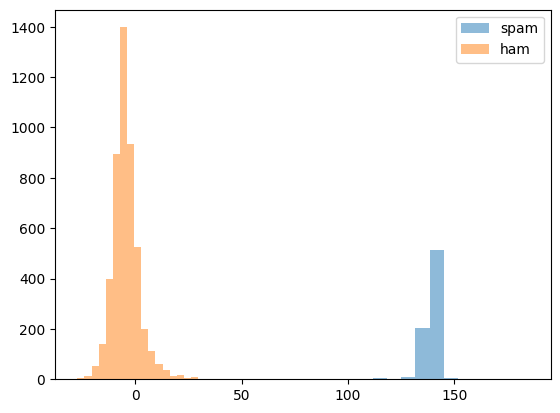

In [7]:
import pandas as pd

csvfile = 'spam_text_message_classification_dataset.csv'
dt_matrix = dtmat_from_csv(csvfile)

df = pd.read_csv(csvfile, header=None, names=['Category', 'Message'], encoding='utf-8', delimiter=',')

spam_indices = [i for i, label in enumerate(df['Category']) if label == 'spam']
ham_indices = [i for i, label in enumerate(df['Category']) if label == 'ham']

X1 = dt_matrix[spam_indices, :]
X2 = dt_matrix[ham_indices, :]

print(f"Number of spam messages: {len(spam_indices)}")
print(f"Number of ham messages: {len(ham_indices)}")

# After running lda on X1 and X2, we encountered the following error:

# LinAlgError: Singular matrix,

# Indicating `Sw` matrix is singular and therefore not invertible. This is because the number of features (columns) in the document-term matrix is greater than the number of samples (rows).

# To handle this issue, we add a regularization term to the `Sw` matrix before taking its inverse. We add a small multiple of the identity matrix to `Sw` to prevent it from being singular. The modified formula for `Sw` would be:

# $S_w = S1 + S2 + \epsilon I$

# where $\epsilon$ is a small constant and $I$ is the identity matrix.

import numpy as np

def lda(X1, X2, epsilon=1e-4):
    mu1 = np.mean(X1, axis=0)
    mu2 = np.mean(X2, axis=0)
    mu = (mu1 + mu2) / 2
    
    S1 = np.cov(X1.T)
    S2 = np.cov(X2.T)
    Sw = S1 + S2 + epsilon * np.identity(X1.shape[1])

    u = np.linalg.solve(Sw, (mu1 - mu2))
    s = u @ mu
    
    return u, s

u, s = lda(X1, X2)

print(f"number of points in class 1: {np.sum(X1 @ u > s)}")
print(f"number of points in class 2: {np.sum(X2 @ u < s)}")

plt.hist(X1 @ u, bins=20, alpha=0.5, label='spam')
plt.hist(X2 @ u, bins=20, alpha=0.5, label='ham')
plt.legend(loc='upper right')
plt.show()

## 4. Kernelized LDA

The kernelized version of LDA is implemented as a kfda package. Its homepage is here: https://pypi.org/project/kfda/
You should install it by running pip3 install kfda

### Question 7

Let $\boldsymbol{x}$ and $\boldsymbol{y}$ be any two columns of your D-T matrix (which you may assume TD-IDF normalized or not, it does not change the problem). Consider the inhomogeneous polynomial kernel 
$$k(\boldsymbol{x},\boldsymbol{y})= (1+<\boldsymbol{x},\boldsymbol{y}>)^n$$
where $n>0$ is integer.

- Suppose that $n=2$, and that the above kernel is used in a kernelized LDA. What are the new axes created in the feature space, that didn't exist when $n=1$? Which of these could be useful, and change the solution computed by LDA in the feature space ?
- Try to classify using this setup, and report your results. Then increase $n$ (moderately). What causes the computational bottleneck of kernelized LDA ?

In [8]:
# When $n = 2$

# $k(x, y) = (1 + \langle x, y \rangle)^2$

# $k(x, y) = 1 + 2\langle x, y \rangle + \langle x, y \rangle^2$

# 3 new axes are created:
# - Constant Term (1): adds a constant axis to the feature space to represent the offset or bias.
# - Linear Term ($2\langle x, y \rangle$): adds a linear axis to the feature space to represent the linear relationship between the two vectors.
# - Quadratic Term ($\langle x, y \rangle^2$): adds a quadratic axis to the feature space to represent the quadratic relationship between the two vectors.

# When we increase $n$, the computational bottleneck of kernelized LDA is caused by the complexity and memory requirements of the kernel matrix

from kfda import Kfda
from sklearn.model_selection import train_test_split

def setup_train_test(dataset_csv_path):
    X = dtmat_from_csv(dataset_csv_path)
    y = [row[0] for row in csv.reader(open(csvfile, errors='ignore'), delimiter=',')]
    X_train, X_test, y_train, y_test = train_test_split(X[1:], y[1:], test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

csvfile = 'spam_text_message_classification_dataset.csv'
X_train, X_test, y_train, y_test = setup_train_test(csvfile)

# for n = 1
n = 1
kfda = Kfda(n_components=1, kernel="poly", degree=n)
kfda.fit(X_train, y_train)
print(f"kfda score n={n}: {kfda.score(X_test, y_test)}")

# lets increase n to 2
n = 2
kfda = Kfda(n_components=1, kernel="poly", degree=n)
kfda.fit(X_train, y_train)
print(f"kfda score n={n}: {kfda.score(X_test, y_test)}")

# lets try SVM

X_train_transformed = kfda.transform(X_train)
X_test_transformed = kfda.transform(X_test)

from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train_transformed, y_train)
print(f"svc score: {clf.score(X_test_transformed, y_test)}")

e:\langage-naturel-esiee\venv\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


kfda score n=1: 0.9865470852017937


e:\langage-naturel-esiee\venv\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


kfda score n=2: 0.9838565022421525
svc score: 0.9775784753363229


### Question 8

We will now slightely improve the above kernel by replacing the natural dot product 
$$<\boldsymbol{x},\boldsymbol{y}>$$ 
by 
$$ \sum_i \min(\boldsymbol{x}_i, \boldsymbol{y}_i) $$
resulting in

$$f(\boldsymbol{x},\boldsymbol{y})= (1+\sum_i \min(\boldsymbol{x}_i, \boldsymbol{y}_i) )^n$$

Is $f$ a positive semidefinite kernel ? Either prove that it is, or give a counter-example.

In [9]:
# - We proved in class that $\sum_i \min(\boldsymbol{x}_i, \boldsymbol{y}_i)$ is a PSD kernel. [proof](https://perso.esiee.fr/~hilairex/5I-SI5/TD1-corr.pdf#page=3)
# - We know that if $k_1(\boldsymbol{x}, \boldsymbol{y})$ and $k_2(\boldsymbol{x}, \boldsymbol{y})$ are PSD kernels, then any linear combination of them with non-negative coefficients is also a PSD kernel. [proof](http://ciml.info/dl/v0_99/ciml-v0_99-ch11.pdf#page=7)

# Let's prove that $f$ is a linear combination of PSD kernels with non-negative coefficients.

# - Let $k(\boldsymbol{x}, \boldsymbol{y}) = \sum_i \min(\boldsymbol{x}_i, \boldsymbol{y}_i)$, which is a PSD kernel.
# - Let $g(t) = (1 + t)^n$, which is a PSD kernel.

# Therefore, $f(\boldsymbol{x}, \boldsymbol{y}) = g(k(\boldsymbol{x}, \boldsymbol{y}))$ is a PSD kernel, because it's the composition of a PSD kernel with a monotonically increasing function.

### Question 9

Irrespective of your answer to question 8, try kfda with $f$ as its kernel. Looking at the source code https://github.com/concavegit/kfda/blob/master/kfda/kfda.py you will notice (line 92) that it relies on the pairwise_kernels function from sklearn to compute the Gram matrix. 

According to sklearn documentation https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_kernels.html the kernel parameter can be a callable, hence you can supply a function of your own as the kernel argument, possibly using the keywords field (kwds).

Report your classification results, possibly varying $n$ (be reasonable with values, high $n$ may cause floating point exceptions, in addition of being meaningless). You should likely obtain decent (~ 75% accuracy, say) but not outstanding results.  This, however, is highly dependent on the dataset and classes you chose.

In [11]:
import numpy as np

n = 2

def custom_kernel(X, Y):
    return (1 + np.sum(np.minimum(X, Y)))**n

csvfile = 'spam_text_message_classification_dataset.csv'
X_train, X_test, y_train, y_test = setup_train_test(csvfile)

kfda = Kfda(n_components=1, kernel=custom_kernel)
kfda.fit(X_train, y_train)
print(f"kfda custom kernel score n={n}: {kfda.score(X_test, y_test)}")

# lets try SVM

X_train_transformed = kfda.transform(X_train)
X_test_transformed = kfda.transform(X_test)

from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train_transformed, y_train)
print(f"svc score: {clf.score(X_test_transformed, y_test)}")

e:\langage-naturel-esiee\venv\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


kfda custom kernel score n=2: 0.5713004484304933
svc score: 0.8663677130044843
